# EDA on Receiving Data

Let's do some EDA! This will help us craft a data story for our dashboard. Some things to keep in mind:

1. We want to be sure that players who are not in the IR/PUP are not counted in overall statistics. 
    1. Corollary: Players who are not injured but also do not show up in the game logs should have their overall statistics negatively impacted by this. 
    2. To achieve this, load in weekly rosters and injury reports. For each Team/Week, find the players who actually suited up. Then, if they don't appear for a particular game, insert 0 receptions, 0 yeards, etc. 

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setting seaborn styles
sns.set()

In [106]:
agg_receiving_data = pd.read_excel('./data/final_gbg_receiver_data.xlsx').drop_duplicates()

# NOTE: This data has non-WR's. Let's only look at wide receivers for now
agg_receiving_data_WR = agg_receiving_data[agg_receiving_data['position'] == 'WR']

agg_receiving_data_WR.head()

player_id          game_id  receiving_yards  avg_yac  \
2   00-0034279  2023_04_DEN_CHI               21     2.00   
3   00-0034827  2023_04_DEN_CHI              131     2.75   
5   00-0036309  2023_04_DEN_CHI               51     4.75   
10  00-0037745  2023_04_DEN_CHI                0     0.00   
11  00-0038941  2023_04_DEN_CHI                0     0.00   

    avg_depth_of_target  receptions  max_target_depth  receiving_touchdowns  \
2                19.000           1                19                     0   
3                13.625           8                29                     1   
5                 8.000           4                14                     0   
10                0.000           0                 0                     0   
11                0.000           0                 0                     0   

    targets_1  targets_2  ...  draft_ovr  twitter_username  height  weight  \
2           1          0  ...      207.0               NaN      77     214   
3           3          2  ...       24.0               NaN      71     210   
5           0          2  ...      173.0        Darnell_M1      71     173   
10          0          0  ...       71.0               NaN      72     200   
11          0          0  ...      133.0               NaN      71     185   

       college  snap_percentage_1  snap_percentage_2  snap_percentage_3  \
2   Notre Dame           0.540541           0.590909           0.615385   
3     Maryland           0.918919           0.909091           1.000000   
5       Tulane           0.729730           0.727273           0.923077   
10   Tennessee           0.054054           0.045455           0.000000   
11  Cincinnati           0.189189           0.181818           0.307692   

    snap_percentage_4  depth_team  
2                0.75           2  
3                1.00           1  
5                0.75           1  
10               0.00           2  
11               0.25           2  

[5 rows x 57 columns]

In [107]:
agg_receiving_data_WR.columns

Index(['player_id', 'game_id', 'receiving_yards', 'avg_yac',
       'avg_depth_of_target', 'receptions', 'max_target_depth',
       'receiving_touchdowns', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'snap_count_1', 'snap_count_2', 'snap_count_3',
       'snap_count_4', 'total_relevant_snaps', 'receiving_fumbles',
       'receiving_fumbles_lost', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 'avg_intended_air_yards',
       'percent_share_of_intended_air_yards', 'name', 'position', 'team',
       'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick',
       'draft_ovr', 'twitter_username', 'height', 'weight', 'college',
       'snap_percentage_1',

<Axes: xlabel='receiving_yards', ylabel='Count'>

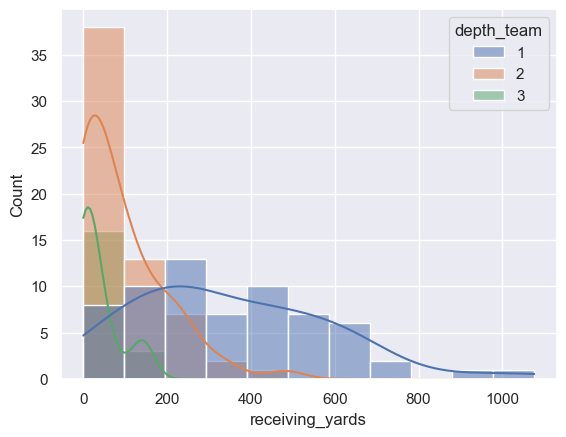

In [108]:
# Let's just start by looking at some histograms
rec_yards_agg = agg_receiving_data_WR.groupby(['player_id', 'depth_team']).receiving_yards.sum().reset_index()
sns.histplot(rec_yards_agg, x='receiving_yards', hue='depth_team', kde=True, palette = 'deep')


<Axes: xlabel='receiving_yards', ylabel='Count'>

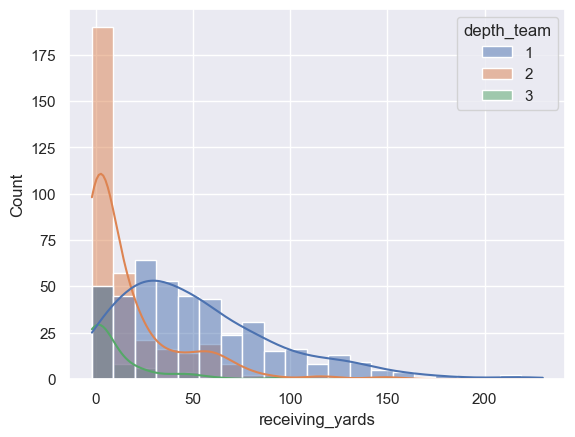

In [109]:
# how about game by game?
sns.histplot(agg_receiving_data_WR, x='receiving_yards', hue='depth_team', kde=True, palette = 'deep')

<Axes: xlabel='receptions', ylabel='Count'>

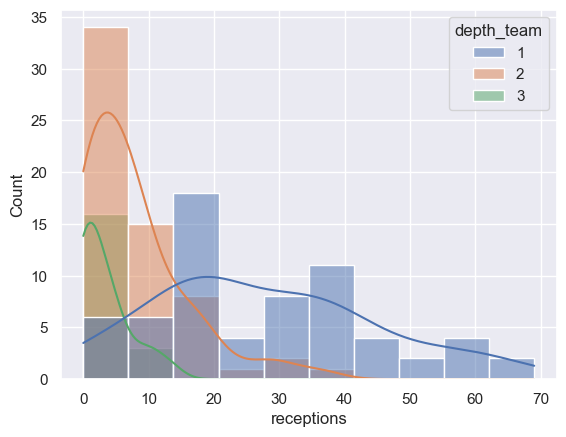

In [110]:
# some fat tails above. receptions should be normal or binomial
rec_agg = agg_receiving_data_WR.groupby(['player_id', 'depth_team']).receptions.sum().reset_index()
sns.histplot(rec_agg, x='receptions', hue='depth_team', kde=True, palette = 'deep')

<Axes: xlabel='receptions', ylabel='Count'>

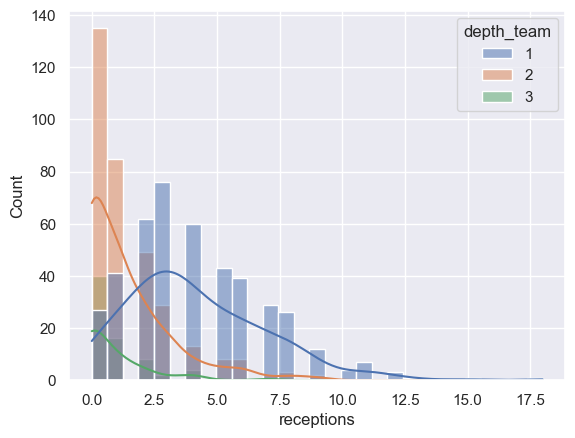

In [111]:
# some fat tails above. receptions should be poisson
sns.histplot(agg_receiving_data_WR, x='receptions', hue='depth_team', kde=True, palette = 'deep')

<Axes: xlabel='avg_separation', ylabel='Count'>

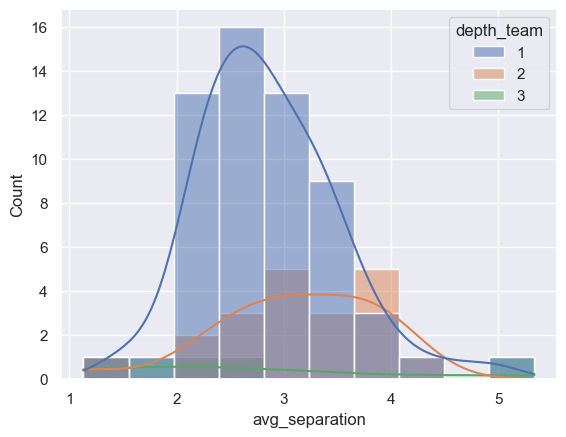

In [112]:
# some fat tails above. receptions should be normal or binomial
sep_agg = agg_receiving_data_WR.groupby(['player_id', 'depth_team']).avg_separation.mean().reset_index()
sns.histplot(sep_agg, x='avg_separation', hue='depth_team', kde=True, palette = 'deep')

In [134]:
# before we look at coorelations we should scalem our features
from sklearn.preprocessing import StandardScaler

# initialize scaler
scaler = StandardScaler()

numerical_columns = ['receiving_yards', 'avg_yac',
       'avg_depth_of_target', 'receptions', 'max_target_depth',
       'receiving_touchdowns', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'snap_count_1', 'snap_count_2', 'snap_count_3',
       'snap_count_4', 'total_relevant_snaps', 'receiving_fumbles',
       'receiving_fumbles_lost', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 'avg_intended_air_yards',
       'percent_share_of_intended_air_yards', 'age','height', 'weight',
       'snap_percentage_1', 'snap_percentage_2', 'snap_percentage_3',
       'snap_percentage_4']

non_num_columns = [x for x in agg_receiving_data.columns if x not in numerical_columns]

# fit to data
scaled = scaler.fit_transform(agg_receiving_data_WR[numerical_columns])
scaled[0]



array([-0.35024205, -0.30363997,  1.8162386 , -0.65064472,  0.64839969,
       -0.42688782, -0.30562734, -0.89163085, -0.88426175, -0.30007751,
       -0.86658291, -0.59973904, -0.18585958, -0.53172265,  0.47114613,
        0.10609572, -0.13445564,  1.90116895,  0.30563585, -0.18534288,
       -0.12238528, -0.50883288, -0.02668083, -0.07597372,  0.12870107,
       -1.21525122, -0.80108579, -1.09697368, -0.40225137, -0.45794326,
       -0.36154672, -0.36893923,  0.8815706 ,         nan,         nan,
               nan,         nan,  0.31850252,  1.90689841,  1.01927701,
        0.05089703,  0.12748059,  0.04771607,  0.47762087])

In [139]:
agg_receiving_data_WR['player_id']

2       00-0034279
3       00-0034827
5       00-0036309
10      00-0037745
11      00-0038941
           ...    
2128    00-0033251
2133    00-0036252
2136    00-0037664
2138    00-0038997
2140    00-0033466
Name: player_id, Length: 837, dtype: object

In [140]:
agg_receiving_data[non_num_columns].reset_index()

index   player_id          game_id                   name position team  \
0         0  00-0024243  2023_04_DEN_CHI         Marcedes Lewis       TE  CHI   
1         1  00-0033757  2023_04_DEN_CHI          Robert Tonyan       TE  CHI   
2         2  00-0034279  2023_04_DEN_CHI  Equanimeous St. Brown       WR  CHI   
3         3  00-0034827  2023_04_DEN_CHI             D.J. Moore       WR  CHI   
4         4  00-0036290  2023_04_DEN_CHI              Cole Kmet       TE  CHI   
...     ...         ...              ...                    ...      ...  ...   
2116   2138  00-0038997  2023_01_JAX_IND             Josh Downs       WR  IND   
2117   2139  00-0033217  2023_01_JAX_IND            Mo Alie-Cox       TE  IND   
2118   2140  00-0033466  2023_01_JAX_IND        Isaiah McKenzie       WR  IND   
2119   2141  00-0035289  2023_01_JAX_IND        Gardner Minshew       QB  IND   
2120   2142  00-0039164  2023_01_JAX_IND     Anthony Richardson       QB  IND   

       birthdate  draft_year  draft_round  draft_pick  draft_ovr  \
0     1984-05-19        2006          1.0        28.0       28.0   
1     1994-04-30        2017          NaN         NaN        NaN   
2     1996-09-30        2018          6.0        33.0      207.0   
3     1997-04-14        2018          1.0        24.0       24.0   
4     1999-03-10        2020          2.0        11.0       43.0   
...          ...         ...          ...         ...        ...   
2116  2001-08-12        2023          3.0        16.0       79.0   
2117  1993-09-19        2017          NaN         NaN        NaN   
2118  1995-04-09        2017          5.0        28.0      172.0   
2119  1996-05-16        2019          6.0         5.0      178.0   
2120  2002-05-22        2023          1.0         4.0        4.0   

     twitter_username                college  depth_team  
0     MarcedesLewis89                   UCLA           3  
1                 NaN          Indiana State           2  
2                 NaN             Notre Dame           2  
3                 NaN               Maryland           1  
4            ColeKmet             Notre Dame           1  
...               ...                    ...         ...  
2116              NaN         North Carolina           1  
2117              NaN  Virginia Commonwealth           1  
2118              NaN                Georgia           2  
2119              NaN       Washington State           2  
2120              NaN                Florida           1  

[2121 rows x 14 columns]

In [144]:
agg_rec_WR_scaled = pd.DataFrame(scaled, columns = numerical_columns)
agg_rec_WR_scaled = agg_rec_WR_scaled.merge(agg_receiving_data_WR[non_num_columns].reset_index(), left_index=True, right_index=True)
agg_rec_WR_scaled.head()

receiving_yards   avg_yac  avg_depth_of_target  receptions  \
0        -0.350242 -0.303640             1.816239   -0.650645   
1         2.471246 -0.115522             1.050118    1.907830   
2         0.419255  0.386126             0.248364    0.445844   
3        -0.888890 -0.805288            -0.891908   -1.016141   
4        -0.888890 -0.805288            -0.891908   -1.016141   

   max_target_depth  receiving_touchdowns  targets_1  targets_2  targets_3  \
0          0.648400             -0.426888  -0.305627  -0.891631  -0.884262   
1          1.507391              1.674907   0.895359   0.376500   2.032495   
2          0.218904             -0.426888  -0.906120   0.376500   0.574117   
3         -0.983683             -0.426888  -0.906120  -0.891631  -0.884262   
4         -0.983683             -0.426888  -0.906120  -0.891631  -0.884262   

   targets_4  ...  position  team   birthdate  draft_year  draft_round  \
0  -0.300078  ...        WR   CHI  1996-09-30        2018          6.0   
1  -0.300078  ...        WR   CHI  1997-04-14        2018          1.0   
2  -0.300078  ...        WR   CHI  1997-10-29        2020          5.0   
3  -0.300078  ...        WR   CHI  1997-05-11        2022          3.0   
4  -0.300078  ...        WR   CHI  2001-10-12        2023          4.0   

   draft_pick  draft_ovr  twitter_username     college  depth_team  
0        33.0      207.0               NaN  Notre Dame           2  
1        24.0       24.0               NaN    Maryland           1  
2        27.0      173.0        Darnell_M1      Tulane           1  
3         7.0       71.0               NaN   Tennessee           2  
4        31.0      133.0               NaN  Cincinnati           2  

[5 rows x 58 columns]

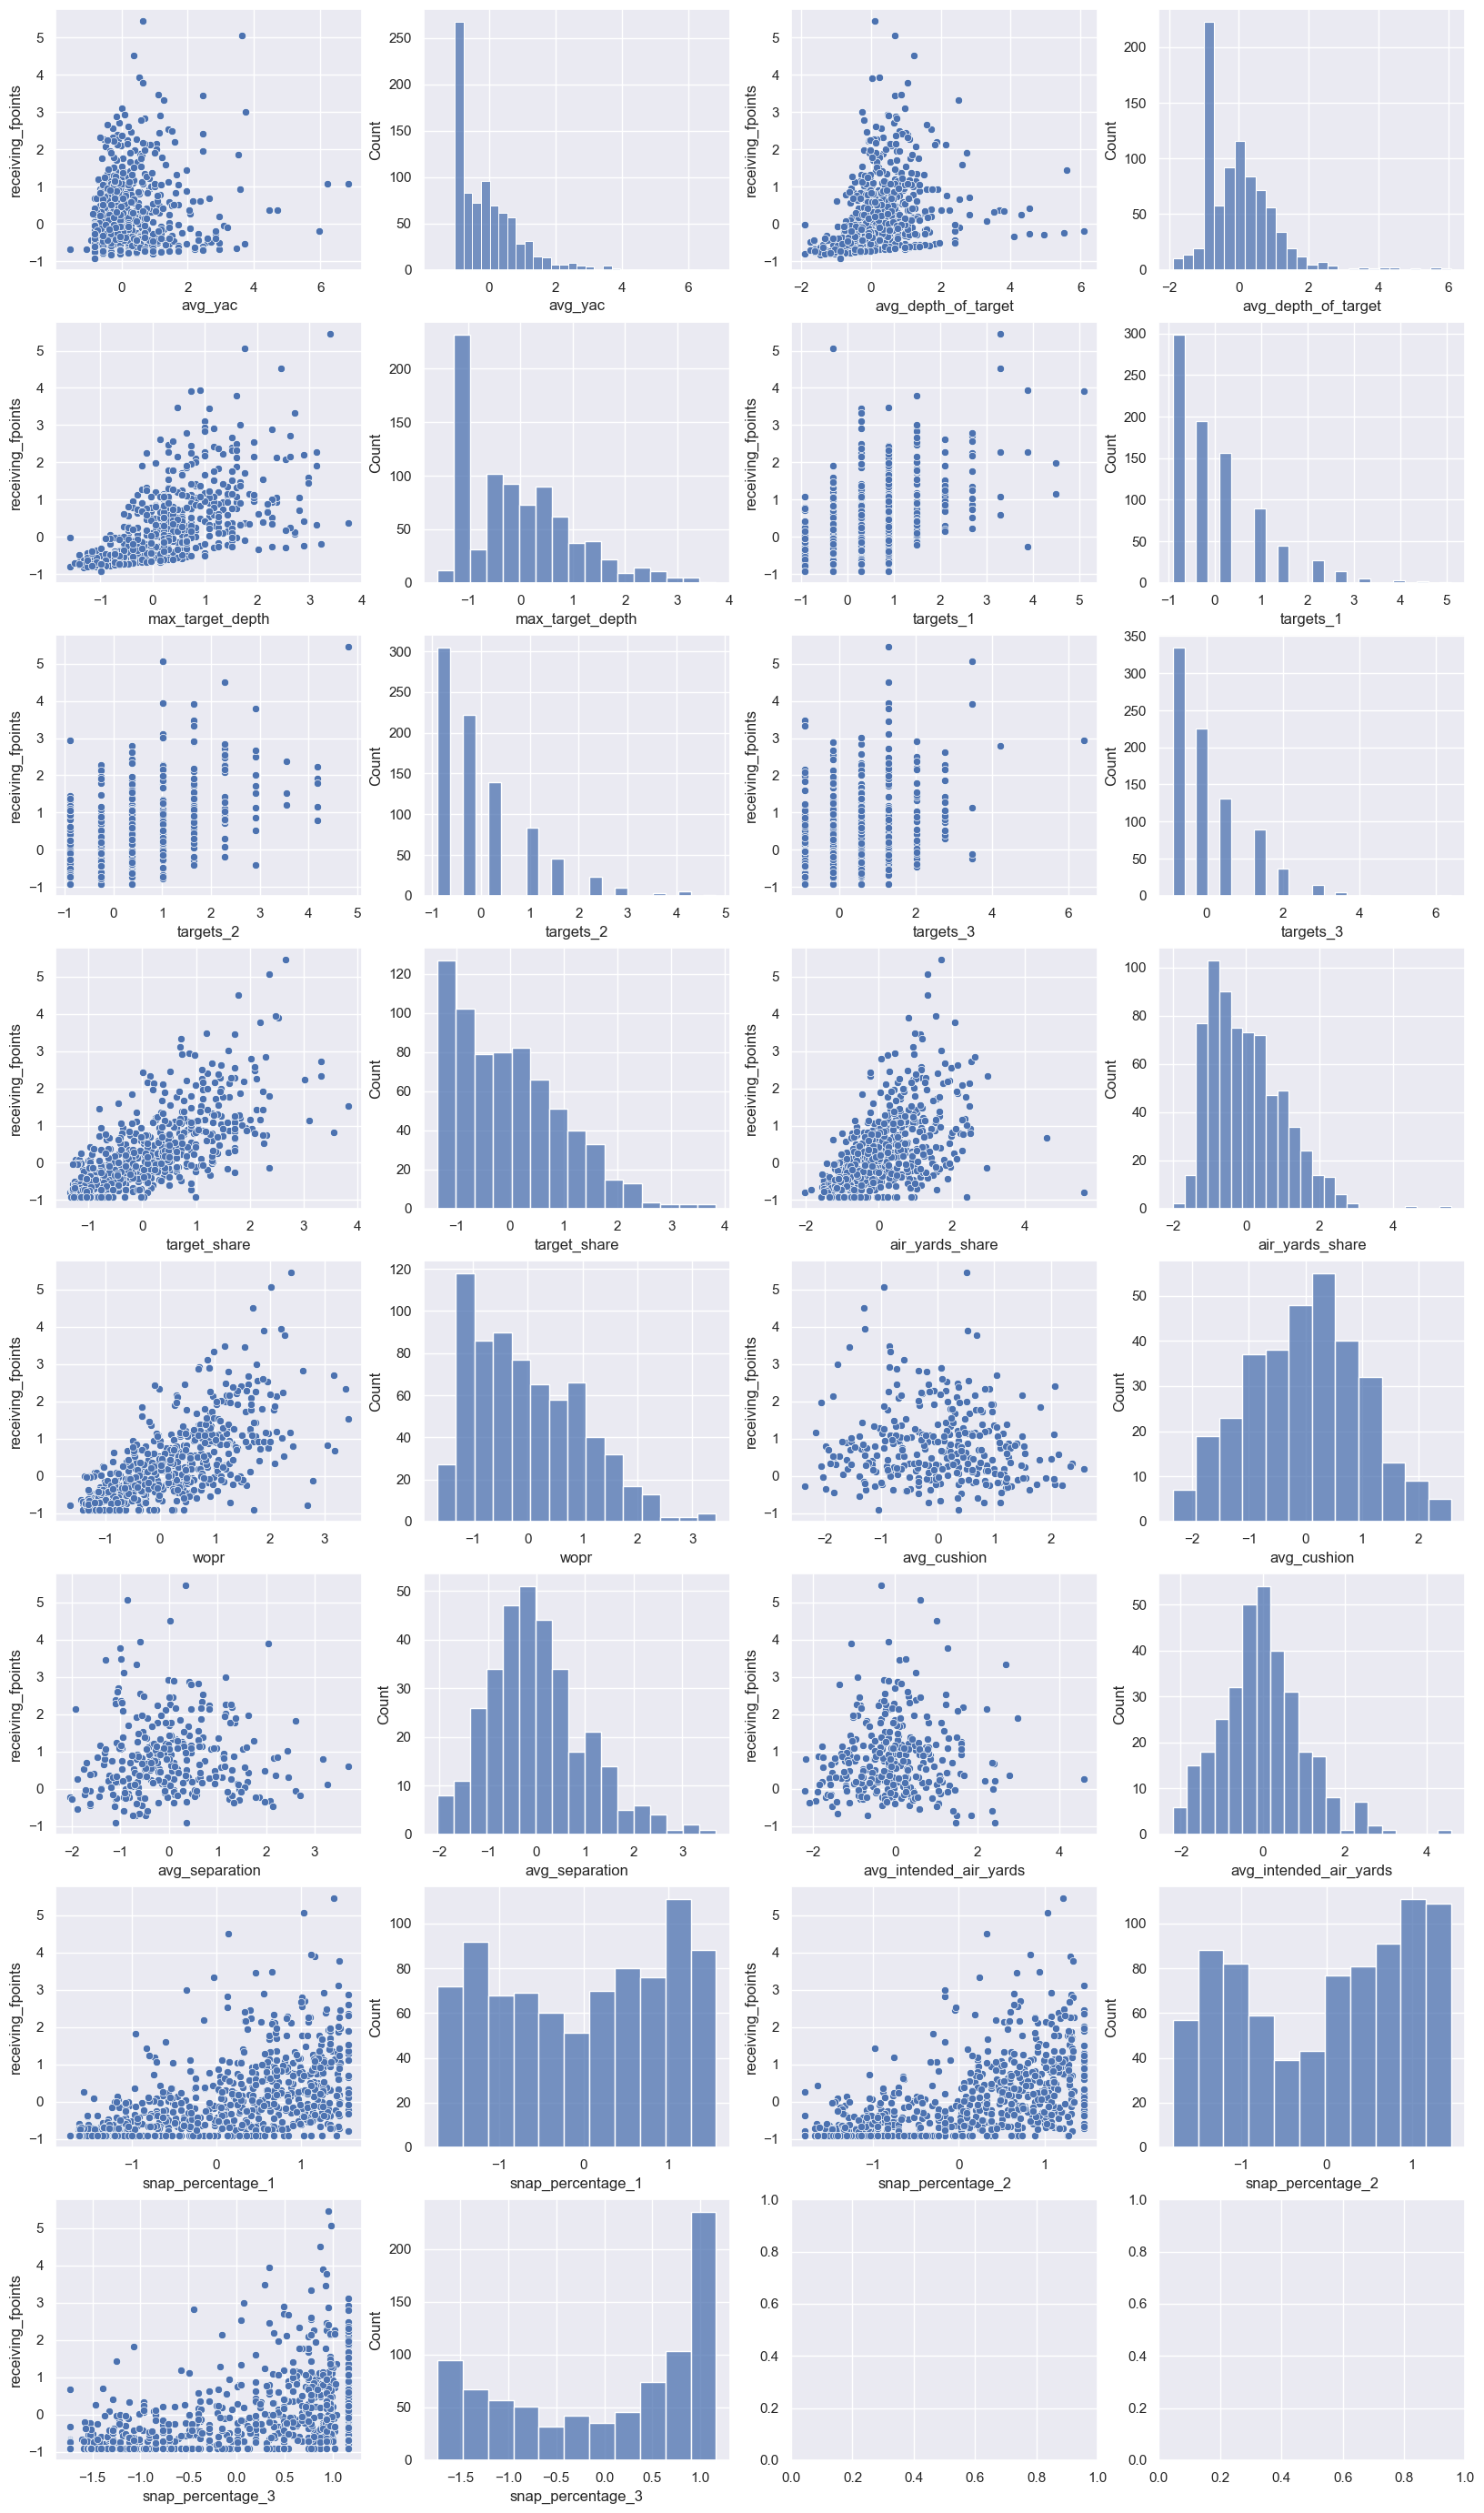

In [149]:
from math import ceil

coor_list = ['avg_yac', 'avg_depth_of_target', 'max_target_depth', 'targets_1', 'targets_2', 'targets_3','target_share', 'air_yards_share','wopr', 'avg_cushion','avg_separation',
               'avg_intended_air_yards','snap_percentage_1', 'snap_percentage_2', 'snap_percentage_3']

coor_var = 'receiving_fpoints'

fig, axes = plt.subplots(ceil(len(coor_list)/2), 4, figsize = (20,35))

for idx, var in enumerate(coor_list):
    if idx%2 == 0:
        sns.scatterplot(data=agg_rec_WR_scaled[[var, coor_var]], x = var, y = coor_var, ax=axes[int(idx/2), 0])
        sns.histplot(data=agg_rec_WR_scaled[var], ax=axes[int(idx/2), 1])
    else:
        sns.scatterplot(data=agg_rec_WR_scaled[[var, coor_var]], x = var, y = coor_var, ax=axes[int((idx-1)/2), 2])
        sns.histplot(data=agg_rec_WR_scaled[var], ax=axes[int((idx-1)/2), 3])

In [ ]:
# should you prioritize young receivers? e.g. do young receivers actually perform better for fantasy than old receivers?
# should we prioritize fast receivers? e.g. do fast receivers actually perform better for fantasy than slow ones?
# what is the most important factor in receiver performance?
# to answer all these we probably need to come up with a normalized fantasy performance. Relative to draft round. Maybe an ROI?


# is there a meaningful increase in fantasy performance when the receiver above you goes out on injury?
# Are there statistical tiers for WR's by the end of the year? i.e. their mean fantasy performance is significantly  (statistically) different from other receivers?
# can we predict fantasy performance?

<Axes: xlabel='weight', ylabel='Count'>

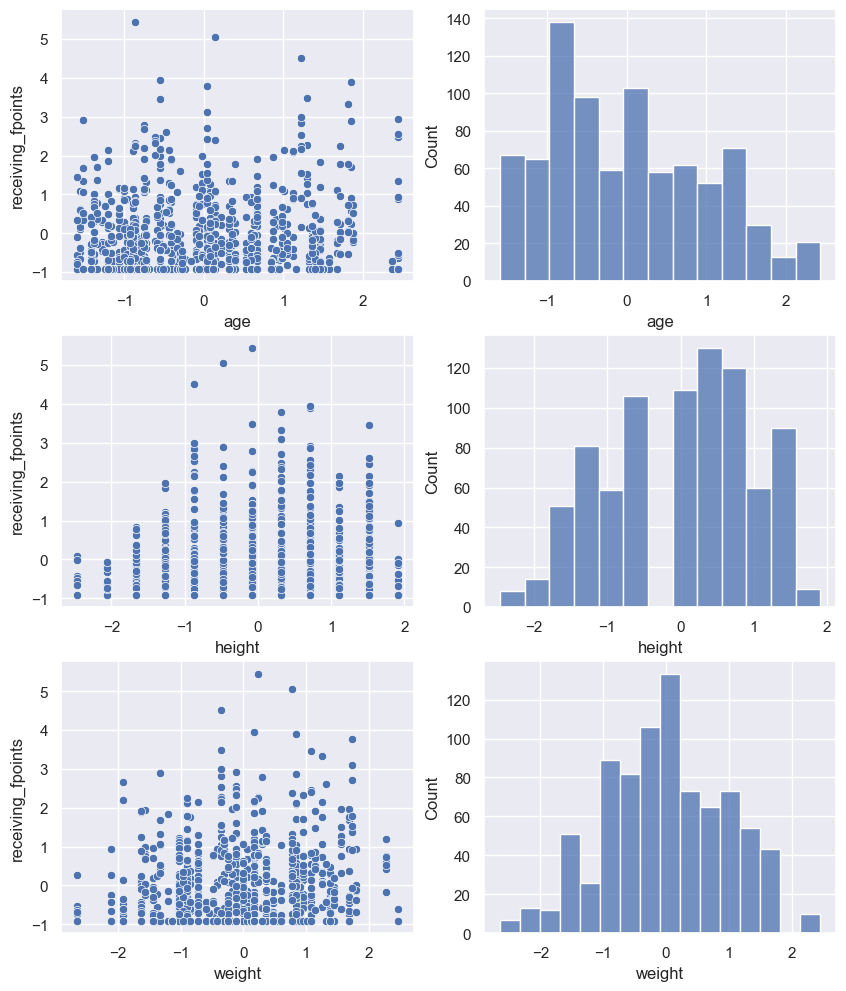

In [146]:
player_coor_list = ['age', 'height', 'weight']

coor_var = 'receiving_fpoints'

fig, axes = plt.subplots(3, 2, figsize = (10, 12)) 


sns.scatterplot(data=agg_rec_WR_scaled[[player_coor_list[0], coor_var]], x = player_coor_list[0], y = coor_var, ax=axes[0, 0])
sns.histplot(data=agg_rec_WR_scaled[player_coor_list[0]], ax=axes[0, 1])

sns.scatterplot(data=agg_rec_WR_scaled[[player_coor_list[1], coor_var]], x = player_coor_list[1], y = coor_var, ax=axes[1, 0])
sns.histplot(data=agg_rec_WR_scaled[player_coor_list[1]], ax=axes[1, 1])

sns.scatterplot(data=agg_rec_WR_scaled[[player_coor_list[2], coor_var]], x = player_coor_list[2], y = coor_var, ax=axes[2, 0])
sns.histplot(data=agg_rec_WR_scaled[player_coor_list[2]], ax=axes[2, 1])


## Prediction

Looks like theres some correlation here. We may be able to predict fantasy performances with this! Some additional features to consider:
1. Injury to primary target in previous game
2. Injury to defensive players (prioritize coverage players)
3. QBR/QB yards/other QB metrics
4. Opposing defense statistics (average yards, tds, receptions given up to WR's)

Once we get all these. We could try PCA to grab important features. 

Structure of time series:
Given a players performance in past games (WR, QB, Defense against, etc.), and some current information (injuries, defense, etc) how many points will a player score in the next game? 

Here's a cool similar project. An idea from this was to compare your model with projections from popular fantasy sites.

### How I want to improve.
1. They're essentially creating a different model for each position group. But all in one step. I want to make separate models for each position type?
2. More interesting metrics. Specifically injury metrics.

### Models to try
1. Random Forest
2. XGBoost
3. Regression
4. LSTM

# EDA on Rushing Data

In [45]:
agg_rushing_data = pd.read_excel('./data/final_gbg_rusher_data.xlsx').drop_duplicates()
agg_rushing_data.head()

player_id rusher_player_name         game_id  rushing_yards   avg_ypc  \
0  00-0026498         M.Stafford  2023_01_LA_SEA           11.0  3.666667   
1  00-0026498         M.Stafford   2023_02_SF_LA           17.0  4.250000   
2  00-0026498         M.Stafford  2023_03_LA_CIN            7.0  7.000000   
3  00-0026498         M.Stafford  2023_04_LA_IND           14.0  7.000000   
4  00-0026498         M.Stafford  2023_06_ARI_LA            2.0  2.000000   

   carries  rushing_touchdowns  opps_1  opps_2  opps_3  ...   age  draft_year  \
0      3.0                 0.0     0.0     2.0     1.0  ...  35.7      2009.0   
1      4.0                 0.0     1.0     2.0     1.0  ...  35.7      2009.0   
2      1.0                 0.0     0.0     0.0     0.0  ...  35.7      2009.0   
3      2.0                 0.0     0.0     1.0     1.0  ...  35.7      2009.0   
4      1.0                 0.0     0.0     1.0     0.0  ...  35.7      2009.0   

   draft_round  draft_pick  draft_ovr  twitter_username  height  weight  \
0          1.0         1.0        1.0           Staff_9    75.0   220.0   
1          1.0         1.0        1.0           Staff_9    75.0   220.0   
2          1.0         1.0        1.0           Staff_9    75.0   220.0   
3          1.0         1.0        1.0           Staff_9    75.0   220.0   
4          1.0         1.0        1.0           Staff_9    75.0   220.0   

   college  depth_team  
0  Georgia           1  
1  Georgia           1  
2  Georgia           1  
3  Georgia           1  
4  Georgia           1  

[5 rows x 49 columns]

In [53]:
rb_1s = agg_rushing_data[(agg_rushing_data['position'] == 'RB') & (agg_rushing_data['depth_team'] == 1)]
rb_1s.sort_values('rushing_yards', ascending=False).head()

player_id rusher_player_name          game_id  rushing_yards    avg_ypc  \
999  00-0039040           D.Achane  2023_03_DEN_MIA          203.0  11.277778   
862  00-0038120           Bre.Hall  2023_05_NYJ_DEN          177.0   8.045455   
485  00-0036275            D.Swift  2023_02_MIN_PHI          175.0   6.250000   
458  00-0036251             Z.Moss  2023_05_TEN_IND          165.0   7.173913   
827  00-0037840         K.Williams   2023_06_ARI_LA          158.0   7.900000   

     carries  rushing_touchdowns  opps_1  opps_2  opps_3  ...   age  \
999     18.0                 2.0    11.0     7.0     0.0  ...  22.1   
862     22.0                 1.0    14.0     8.0     0.0  ...  22.4   
485     28.0                 1.0    14.0    12.0     2.0  ...  24.8   
458     23.0                 2.0    11.0     9.0     3.0  ...  25.9   
827     20.0                 1.0    12.0     7.0     1.0  ...  23.2   

     draft_year  draft_round  draft_pick  draft_ovr  twitter_username  height  \
999      2023.0          3.0        21.0       84.0               NaN    69.0   
862      2022.0          2.0         4.0       36.0               NaN    73.0   
485      2020.0          2.0         3.0       35.0       DAndreSwift    69.0   
458      2020.0          3.0        22.0       86.0         PresMoss2    69.0   
827      2022.0          5.0        21.0      164.0               NaN    69.0   

     weight     college  depth_team  
999   188.0   Texas A&M           3  
862   220.0  Iowa State           1  
485   215.0     Georgia           2  
458   205.0        Utah           1  
827   194.0  Notre Dame           1  

[5 rows x 49 columns]

In [54]:
agg_rb_1s = rb_1s.groupby(['player_id', 'name']).agg(
    total_rushing_yards = ('rushing_yards', 'sum'),
    avg_rushing_yards = ('rushing_yards', 'mean'),
    avg_ypc = ('avg_ypc', 'mean'),
    total_carries = ('carries', 'sum'),
    avg_carries = ('carries', 'mean'),
    total_tds = ('rushing_touchdowns', 'sum'),
    avg_tds = ('rushing_touchdowns', 'mean'),
    opps_1 = ('opps_1', 'sum'), 
    opps_2 = ('opps_2', 'sum'), 
    opps_3 = ('opps_3', 'sum'), 
    opps_4 = ('opps_4', 'sum'), 
    total_opps = ('total_opps', 'sum'),
    avg_opps = ('total_opps', 'mean'),
    rz_opps = ('rz_opps', 'sum'), 
    avg_rz_opps = ('rz_opps', 'mean'),
    garbage_fpoints = ('garbage_time_fpoints', 'sum'),
    rushing_fpoints = ('rushing_fpoints', 'sum'),
    avg_garbage_fpoints = ('garbage_time_fpoints', 'mean'),
    avg_rushing_fpoints = ('rushing_fpoints', 'mean'),
    snap_count_1 = ('snap_count_1', 'sum'),
    snap_count_2 = ('snap_count_2', 'sum'),
    snap_count_3 = ('snap_count_3','sum'),
    snap_count_4 = ('snap_count_4', 'sum'),
    avg_snaps = ('total_relevant_snaps', 'mean'),
    total_relevant_snaps = ('total_relevant_snaps', 'sum'),
    rushing_fumbles = ('rushing_fumbles', 'sum'),
    rushing_fumbles_lost = ('rushing_fumbles_lost', 'sum'), 
    rushing_yards_before_contact_avg = ('rushing_yards_before_contact_avg', 'mean'), 
    rushing_yards_after_contact_avg = ('rushing_yards_after_contact_avg', 'mean'), 
    rushing_broken_tackles_avg = ('rushing_broken_tackles', 'mean'),
    efficiency_avg = ('efficiency', 'mean'), 
    expected_rush_yards_avg = ('expected_rush_yards', 'mean'), 
    rush_yards_over_expected_avg = ('rush_yards_over_expected', 'mean'),
    rush_yards_over_expected_per_att_avg = ('rush_yards_over_expected_per_att', 'mean')
).reset_index()

In [55]:
agg_rb_1s = agg_rb_1s[agg_rb_1s['avg_opps'] > 5]
agg_rb_1s.head()

player_id                 name  total_rushing_yards  avg_rushing_yards  \
7   00-0031687       Raheem Mostert                605.0          67.222222   
11  00-0032764        Derrick Henry                601.0          75.125000   
13  00-0033045      Ezekiel Elliott                277.0          30.777778   
14  00-0033280  Christian McCaffrey                652.0          81.500000   
15  00-0033293          Aaron Jones                196.0          39.200000   

     avg_ypc  total_carries  avg_carries  total_tds   avg_tds  opps_1  ...  \
7   5.211348          109.0    12.111111       11.0  1.222222    81.0  ...   
11  4.394667          137.0    17.125000        4.0  0.500000    77.0  ...   
13  3.631782           73.0     8.111111        2.0  0.222222    35.0  ...   
14  4.603077          137.0    17.125000        9.0  1.125000    74.0  ...   
15  4.064682           49.0     9.800000        2.0  0.400000    27.0  ...   

    total_relevant_snaps  rushing_fumbles  rushing_fumbles_lost  \
7                  345.0              2.0                   1.0   
11                 287.0              0.0                   0.0   
13                 220.0              0.0                   0.0   
14                 418.0              2.0                   2.0   
15                 150.0              1.0                   1.0   

    rushing_yards_before_contact_avg  rushing_yards_after_contact_avg  \
7                           3.062500                         1.925000   
11                          2.414286                         1.971429   
13                          2.575000                         1.150000   
14                          2.550000                         2.087500   
15                          3.375000                         0.800000   

    rushing_broken_tackles_avg  efficiency_avg  expected_rush_yards_avg  \
7                     0.750000        3.930430                55.840520   
11                    1.142857        4.326275                66.042565   
13                    0.000000        3.445790                53.473393   
14                    0.750000        4.213451                62.936298   
15                    0.500000             NaN                      NaN   

    rush_yards_over_expected_avg  rush_yards_over_expected_per_att_avg  
7                      20.659480                              1.398453  
11                      7.957435                              0.490662  
13                      2.026607                              0.117388  
14                     15.563702                              0.849327  
15                           NaN                                   NaN  

[5 rows x 36 columns]

In [57]:
# let's get some key rankings
agg_rb_1s['total_rushing_yards_rank'] = agg_rb_1s['total_rushing_yards'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['avg_ypc_rank'] = agg_rb_1s['avg_ypc'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['total_carries_rank'] = agg_rb_1s['total_carries'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['avg_carries_rank'] = agg_rb_1s['avg_carries'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['total_tds_rank'] = agg_rb_1s['total_tds'].fillna(0).rank(method='dense', ascending=False).astype(int)
# agg_rb_1s['avg_tds_rank'] = agg_rb_1s['avg_tds'].rank(method='dense', ascending=False).astype(int)
agg_rb_1s['total_opps_rank'] = agg_rb_1s['total_opps'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['avg_opps_rank'] = agg_rb_1s['avg_opps'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['rz_opps_rank'] = agg_rb_1s['rz_opps'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['garbage_fpoints_rank'] = agg_rb_1s['garbage_fpoints'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['avg_snaps_rank'] = agg_rb_1s['avg_snaps'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['total_relevant_snaps_rank'] = agg_rb_1s['total_relevant_snaps'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['rushing_fumbles_rank'] = agg_rb_1s['rushing_fumbles'].fillna(0).rank(method='dense').astype(int)
agg_rb_1s['rushing_fumbles_lost_rank'] = agg_rb_1s['rushing_fumbles_lost'].fillna(0).rank(method='dense').astype(int)
agg_rb_1s['rushing_yards_before_contact_avg_rank'] = agg_rb_1s['rushing_yards_before_contact_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['rushing_yards_after_contact_avg_rank'] = agg_rb_1s['rushing_yards_after_contact_avg'].fillna(0).rank(method='dense', ascending=False).astype(int) 
agg_rb_1s['rushing_broken_tackles_avg_rank'] = agg_rb_1s['rushing_broken_tackles_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['efficiency_avg_rank'] = agg_rb_1s['efficiency_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['expected_rush_yards_avg_rank'] = agg_rb_1s['expected_rush_yards_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['rush_yards_over_expected_avg_rank'] = agg_rb_1s['rush_yards_over_expected_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)
agg_rb_1s['rush_yards_over_expected_per_att_avg_rank'] = agg_rb_1s['rush_yards_over_expected_per_att_avg'].fillna(0).rank(method='dense', ascending=False).astype(int)

In [58]:
agg_rb_1s[agg_rb_1s['name'] == 'Rachaad White'][[col for col in agg_rb_1s if '_rank' in col]]

total_rushing_yards_rank  avg_ypc_rank  total_carries_rank  \
92                        26            44                  10   

    avg_carries_rank  total_tds_rank  total_opps_rank  avg_opps_rank  \
92                14               7               11             15   

    rz_opps_rank  garbage_fpoints_rank  avg_snaps_rank  \
92             8                    18               6   

    total_relevant_snaps_rank  rushing_fumbles_rank  \
92                          4                     1   

    rushing_fumbles_lost_rank  rushing_yards_before_contact_avg_rank  \
92                          1                                     36   

    rushing_yards_after_contact_avg_rank  rushing_broken_tackles_avg_rank  \
92                                    46                               14   

    efficiency_avg_rank  expected_rush_yards_avg_rank  \
92                   18                            21   

    rush_yards_over_expected_avg_rank  \
92                                 54   

    rush_yards_over_expected_per_att_avg_rank  
92                                         52

In [59]:
agg_rb_1s.to_excel('./proving_daniel_wrong.xlsx', index=False)